# Hotel Customer Segmentation & Marketing Personalization with Spark Clustering and Kafka Cancellation Prediction

## Imort libraries 

In [2]:
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
from scipy.stats import entropy

# PySpark
from pyspark.sql import functions as F
from pyspark.sql.functions import col, from_json, explode, expr
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, ArrayType
from pyspark.sql import SparkSession

# PySpark ML
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import (
    VectorAssembler,
    StringIndexer,
    OneHotEncoder,
    PCA
)
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)

# Pandas display settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [3]:
# Global collector for predictions across all batches
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
global_prediction_store = spark.createDataFrame([], schema="y_label INT, prediction DOUBLE, probability ARRAY<DOUBLE>")


## Load Data

In [4]:
# Import the tables
df_2022 = pd.read_excel("Eilat_2022.xlsx")

In [5]:
df_2023 = pd.read_excel("Eilat_2023.xlsx")

/home/linuxu/anaconda3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [6]:
df_2024 = pd.read_excel("Eilat_2024.xlsx")

/home/linuxu/anaconda3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [7]:
# Combine all dataframes
combined_df = pd.concat([df_2022, df_2023, df_2024], ignore_index=True)

In [8]:
combined_df_raw = combined_df.copy()

#### Columns Check

In [9]:
# Check number of columns
print(f"Columns in Eilat_2022: {df_2022.shape[1]}")
print(f"Columns in Eilat_2023: {df_2023.shape[1]}")
print(f"Columns in Eilat_2024: {df_2024.shape[1]}")

# Check if column names match
columns_match = df_2022.columns.equals(df_2023.columns) and df_2022.columns.equals(df_2024.columns)

if columns_match:
    print("✅ All DataFrames have the same column names.")
else:
    print("❌ Column names are different across DataFrames.")
    print("Eilat_2022 Columns:", df_2022.columns.tolist())
    print("Eilat_2023 Columns:", df_2023.columns.tolist())
    print("Eilat_2024 Columns:", df_2024.columns.tolist())

Columns in Eilat_2022: 66
Columns in Eilat_2023: 66
Columns in Eilat_2024: 66
✅ All DataFrames have the same column names.


### EDA

#### Data Description 

In [10]:
# Detailed column info
print(combined_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169113 entries, 0 to 169112
Data columns (total 66 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   c_master_id             169113 non-null  int64         
 1   c_reservation_id        169113 non-null  int64         
 2   c_reservation_status    169113 non-null  object        
 3   c_arrival_date          169113 non-null  datetime64[ns]
 4   c_depart_date           169113 non-null  datetime64[ns]
 5   guest_name              169113 non-null  object        
 6   c_room_category         169113 non-null  object        
 7   c_adults                169113 non-null  int64         
 8   c_juniors               169113 non-null  int64         
 9   c_children              169113 non-null  int64         
 10  c_babies                169113 non-null  int64         
 11  c_taken_clerk           169113 non-null  object        
 12  c_taken_date_time       169113

In [11]:
# Count unique values in each column
distinct_counts = combined_df.nunique().sort_values(ascending=False)
print(distinct_counts)

c_guest_id                162508
c_master_id               152325
c_taken_date_time         152213
c_voucher                 146056
guest_name                116634
mobile                    105549
c_e_mail                   98471
c_phone                    90053
price_local                51589
guest_comments             36081
passport_id                31474
c_price_amount             28870
c_price_amount.1           28450
backoffice_number          15732
c_company_code             15310
c_date_of_birth            11162
c_agent_company_name        8665
iata_number                 8291
spa_folder                  4570
c_depart_date               1351
c_arrival_date              1350
c_group_code                 808
c_price_code                 547
rooms                        396
guests                       384
c_adults                     339
c_agent_code                 325
c_max_commitment             270
c_children                   134
c_taken_clerk                127
c_national

In [12]:
# Define column categories
numerical_columns = [
    "c_guest_id", "c_master_id", "price_local", "c_price_amount", "c_price_amount.1",
    "rooms", "guests", "c_adults", "c_children", "c_babies", "c_nights", "c_max_commitment",
    "c_currency_rate2", "c_manual_rate", "c_guaranteed", "guest_agrees_email", "c_user_id",
    "c_receives_bonus", "spa_folder", "c_juniors", "c_reservation_id"  # Added missing numerical columns
]

categorical_columns = [
    "c_price_code", "c_agent_code", "c_nationality_code", "nationality_name",
    "market_segmant_name", "c_market_segment", "c_source", "c_reservation_status",
    "c_room_category", "c_room_type", "c_plan", "c_currency_rate2", "c_price_currency",
    "credit_card_token", "credit_card_expiry", "credit_card", "c_vip_code",
    "type_c", "type_a", "c_city", "c_hotel_name", "c_company_code", "c_cro",
    "c_grai_detail", "c_israeli_currency", "credit_card_name"  # Added missing categorical columns
]

text_columns = [
    "guest_name", "guest_comments", "c_e_mail", "c_phone", "mobile", "passport_id",
    "c_voucher", "iata_number", "backoffice_number", "c_group_code", "c_agent_company_name",
    "c_group_coordinator", "c_delegate_nationality", "c_taken_clerk"
]

datetime_columns = [
    "c_arrival_date", "c_depart_date", "c_taken_date_time", "c_date_of_birth"
]

# Columns to drop (since they have 0 non-null values)
columns_to_drop = ["c_statistic_source", "price_service"]
combined_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Final check to ensure all columns are categorized
all_columns = set(combined_df.columns)
categorized_columns = set(numerical_columns + categorical_columns + text_columns + datetime_columns)

missing_columns = all_columns - categorized_columns

if missing_columns:
    print("❌ The following columns were still not categorized:", missing_columns)
else:
    print("✅ All columns are now properly categorized!")

✅ All columns are now properly categorized!


In [13]:
# Select only numerical columns (both int and float)
num_columns = combined_df.select_dtypes(include=['number'])

# IQR method to detect outliers on numerical columns
Q1 = num_columns.quantile(0.25)
Q3 = num_columns.quantile(0.75)
IQR = Q3 - Q1

# Detect outliers for numerical columns
outliers = ((num_columns < (Q1 - 1.5 * IQR)) | (num_columns > (Q3 + 1.5 * IQR)))

# Summarize the number of outliers per numerical column
outliers_summary = outliers.sum()

# Sort outliers summary in descending order
outliers_summary_sorted = outliers_summary.sort_values(ascending=False)

# Display sorted outliers summary
print("Outliers summary (number of outliers per numerical column, sorted descending):")
print(outliers_summary_sorted)


Outliers summary (number of outliers per numerical column, sorted descending):
guest_agrees_email    29407
c_babies              23496
c_reservation_id      16336
price_local            8345
c_price_amount         6010
c_price_amount.1       6003
c_adults               5375
c_manual_rate          4984
spa_folder             4907
rooms                  2164
c_guaranteed           1942
guests                 1141
c_nights                953
c_children              444
c_max_commitment        325
c_user_id                63
c_juniors                17
c_currency_rate2         16
c_master_id               0
c_receives_bonus          0
c_guest_id                0
dtype: int64


#### Missing Values

In [14]:
# Calculate the total number of missing values in the dataset
total_missing = combined_df.isnull().sum().sum()

# Calculate the total number of values in the dataset
total_values = combined_df.size

# Calculate the overall percentage of missing values
missing_percentage = (total_missing / total_values) * 100

# Print the result
print(f"Overall Missing Value Percentage: {missing_percentage:.2f}%")


Overall Missing Value Percentage: 20.03%


In [15]:
# Check missing values in each column
missing_values = combined_df.isnull().sum()
missing_percent = (missing_values / len(combined_df)) * 100

# Create a DataFrame to display missing value stats
missing_df = pd.DataFrame({
    "Missing Values": missing_values,
    "Percentage (%)": missing_percent
}).sort_values(by="Percentage (%)", ascending=False)

display(missing_df)

,Missing Values,Percentage (%)
c_group_coordinator,169109,99.997635
c_group_code,167358,98.962232
c_delegate_nationality,167326,98.943310
c_max_commitment,167324,98.942127
c_cro,153167,90.570802
c_user_id,152265,90.037431
c_date_of_birth,147497,87.218014
c_company_code,143690,84.966856
iata_number,143188,84.670014
passport_id,107935,63.824189


#### Duplicates

In [16]:
# Check for fully duplicated rows (all columns must match)
duplicate_rows = combined_df.duplicated(keep=False)  # Keep=False -> Mark all duplicates, not just second occurrence

# Count duplicate records
num_exact_duplicates = duplicate_rows.sum()
print(f"🔍 Found {num_exact_duplicates} fully duplicated rows.")

# Display duplicate records if any exist
if num_exact_duplicates > 0:
    display(combined_df[duplicate_rows].head(10))  # Show first 10 duplicate rows
    
combined_df = combined_df.drop_duplicates()
print("✅ Fully duplicated rows removed.")

🔍 Found 168 fully duplicated rows.


,c_master_id,c_reservation_id,c_reservation_status,c_arrival_date,c_depart_date,guest_name,c_room_category,c_adults,c_juniors,c_children,c_babies,c_taken_clerk,c_taken_date_time,c_hotel_name,c_city,c_room_type,c_guaranteed,c_vip_code,c_price_code,c_receives_bonus,c_agent_company_name,c_grai_detail,c_group_code,c_delegate_nationality,c_group_coordinator,c_price_currency,c_price_amount,c_plan,c_market_segment,c_nationality_code,c_cro,c_max_commitment,c_nights,c_manual_rate,type_a,c_agent_code,c_company_code,c_currency_rate2,c_israeli_currency,c_price_amount.1,price_local,c_source,rooms,type_c,c_voucher,guests,c_e_mail,c_phone,mobile,passport_id,c_date_of_birth,market_segmant_name,nationality_name,backoffice_number,iata_number,guest_comments,spa_folder,guest_agrees_email,c_user_id,credit_card,credit_card_name,credit_card_token,credit_card_expiry,c_guest_id
62519,294258,1,chkou,2024-01-04,2024-01-04,נהג נהג- מכבי גדרה,Suite,1,0,0,0,advad,2024-01-01 15:25:41,Club Hotel Eilat,Eilat,Studio,1.0,3,day uze,1.0,קידום מכירות,i,NaN,NaN,NaN,NIS,10.00,RO,OTH,ISR,0,NaN,0,0.0,,100000032000,NaN,1.0,NIS,10.00,10.00,OTH,NaN,,NaN,1,NaN,NaN,0506069999,NaN,NaT,OTH,Israel,850000010,NaN,NaN,0,0,0.0,,,...,,592300374
65265,294129,1,chkou,2024-01-05,2024-01-06,Volkova Anna,CARB,2,0,3,0,interface,2024-01-01 01:23:06,Club Hotel Eilat,Eilat,Caribbean,1.0,6,BB,1.0,Booking,i,NaN,NaN,NaN,NIS,1395.00,B/B,InterE,ISR,NaN,NaN,1,1.0,,100000011100,NaN,1.0,NIS,1395.00,1395.00,Net,1.0,,4026402759,5,aninia@mail.ru,+972 545288837,0545288837,332750132,1982-02-25,Internet External,Israel,220200635,NaN,\n\nGuest Check-in info by Duve\n\n1. Arrival ...,0,1,NaN,,,...,,592300250
65266,294130,1,chkou,2024-01-01,2024-01-04,סורוקין סמי,Suite,1,0,0,0,interface,2024-01-01 04:23:07,Club Hotel Eilat,Eilat,Suite,1.0,2,HomeSite,1.0,Calcal,i,NaN,NaN,NaN,NIS,235.00,RO,InterC,ISR,NaN,NaN,3,1.0,,110000173 00,NaN,1.0,NIS,422.31,892.31,InternetC,3.0,,10100847,1,sami.sorokin.1993@gmail.com,0524372364,0524372364,NaN,NaT,Internet Club Hotel,Israel,NaN,NaN,\n,0,1,NaN,,,...,,592300251
65267,294131,1,can,2024-02-29,2024-03-03,מויאל אבי,Suite,2,0,0,0,interface,2024-01-01 08:11:08,Club Hotel Eilat,Eilat,Suite,1.0,6,BB,1.0,Booking,i,NaN,NaN,NaN,NIS,320.40,B/B,InterE,ISR,NaN,NaN,3,1.0,,100000011100,NaN,1.0,NIS,320.40,1599.30,Net,3.0,,4026467073,2,bmvyl.676241@guest.booking.com,+972 50 855 0557,+972 50 855 0557,NaN,NaT,Internet External,Israel,220200635,NaN,\n,0,1,NaN,,,...,,592300252
65268,294132,1,can,2024-01-25,2024-01-27,אברמסון רוזית,Suite,2,0,2,0,interface,2024-01-01 08:35:08,Club Hotel Eilat,Eilat,Suite,1.0,NaN,HomeSite,1.0,Internet,i,NaN,NaN,NaN,NIS,1036.45,B/B,InterC,ISR,NaN,NaN,2,1.0,,100000031200,NaN,1.0,NIS,1036.45,2073.85,InternetC,2.0,,10100848,4,rozita@nioi.gov.il,0506284437,0506284437,NaN,NaT,Internet Club Hotel,Israel,,NaN,\n,0,1,NaN,,,...,,592300253
65270,294134,1,chkou,2024-01-11,2024-01-14,חן עמיתי,Suite,5,0,0,0,interface,2024-01-01 08:54:10,Club Hotel Eilat,Eilat,Suite,1.0,2,HomeSite,1.0,Isracard,i,NaN,NaN,NaN,NIS,795.15,H/B,InterC,ISR,NaN,NaN,3,1.0,,110000172 00,NaN,1.0,NIS,1214.81,3224.77,InternetC,3.0,,10100849,5,saritchen.cosmetic@gmail.com,0524768642,0524768642,NaN,NaT,Internet Club Hotel,Israel,NaN,NaN,\n\nGuest Check-in info by Duve\n\n1. Arrival ...,0,1,NaN,,,...,,592300254
65282,294146,1,can,2024-04-17,2024-04-20,שםטוב מירב,Suite,2,0,2,0,interface,2024-01-01 09:53:06,Club Hotel Eilat,Eilat,Suite,1.0,2,HomeSite,1.0,Isracard,i,NaN,NaN,NaN,NIS,929.66,RO,InterC,ISR,NaN,NaN,3,1.0,,110000172 00,NaN,1.0,NIS,929.66,3487.15,InternetC,3.0,,10100850,4,meiravsh2014@gmail.com,0523980446,0523980446,NaN,NaT,Internet Club Hotel,Israel,NaN,NaN,\n,0,1,NaN,,,...,,592300266
65297,294161,1,chkou,2024-01-04,2024-01-05,שגיב יואב,SEXE,5,0,0,0,interface,2024-01-01 10:06:05,Club Hotel Eilat,Eilat,Caribbean,1.0,2,HomeSite,1.0,Kpolice,i,NaN,NaN,NaN,NIS,1113.21,B/B,InterC,ISR,NaN,NaN,1,1.0,,110000236 00,NaN,1.0,NIS,1113.21,1113.21,InternetC,1.0,,10100851,5,yoav.sag@gmail.com,0504062498,0504062498,NaN

✅ Fully duplicated rows removed.


#### Outliers

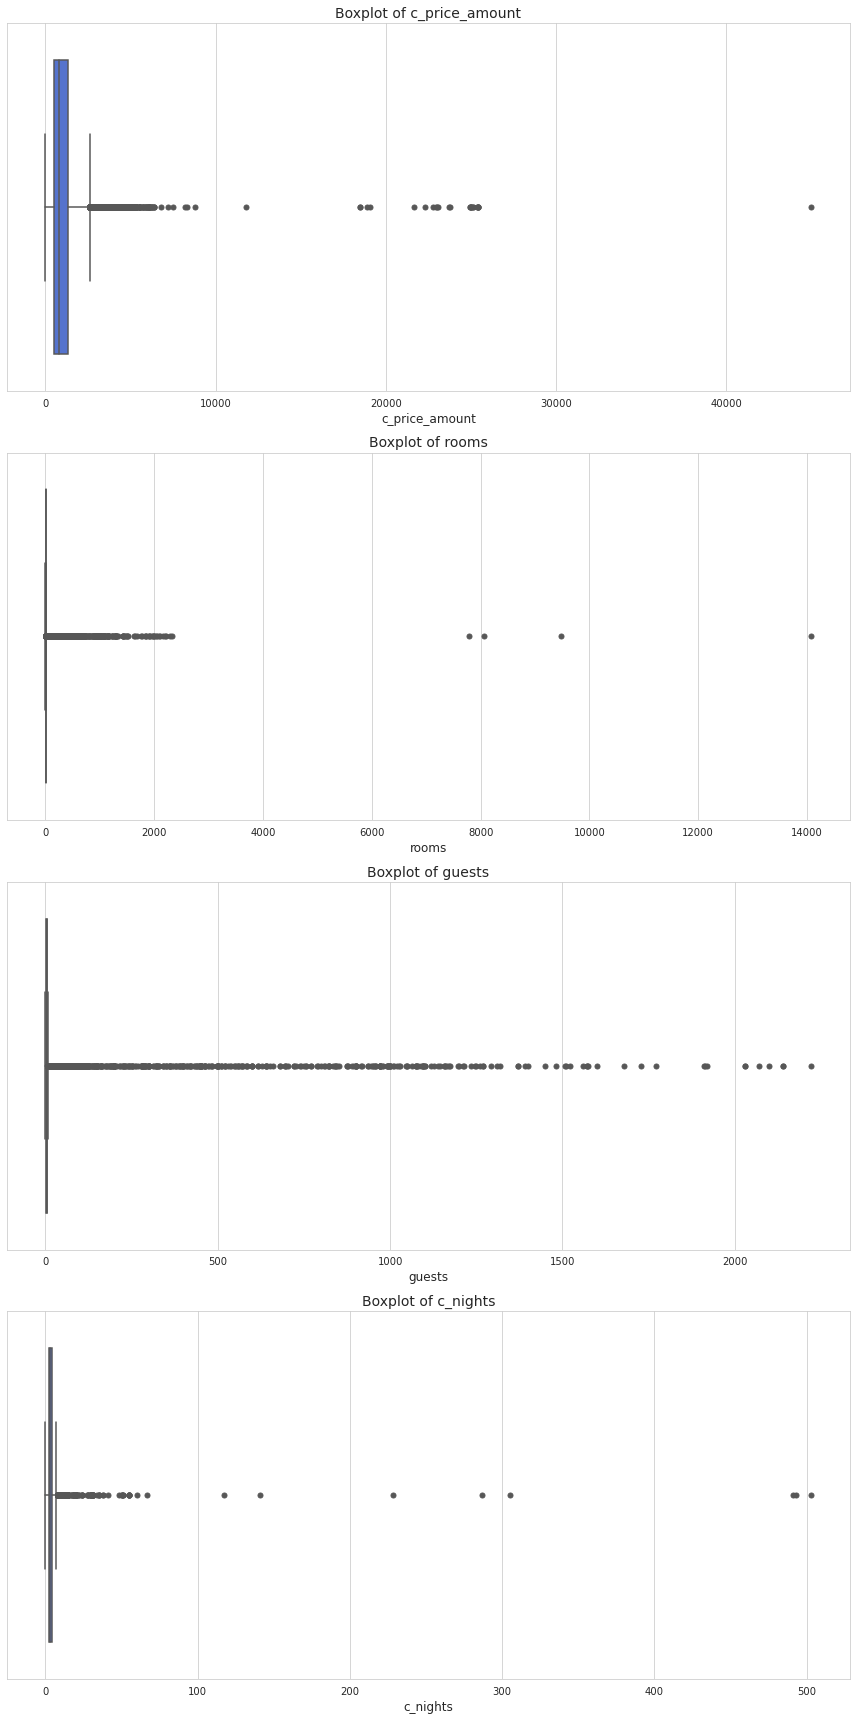

In [17]:
# Set plot style
sns.set_style("whitegrid")

# Select numerical columns for outlier analysis
outlier_columns = ["c_price_amount", "rooms", "guests", "c_nights"]

# Plot improved boxplots
plt.figure(figsize=(12, 6 * len(outlier_columns)))  # Adjust figure size dynamically
for i, col in enumerate(outlier_columns, 1):
    plt.subplot(len(outlier_columns), 1, i)  # Create subplots
    sns.boxplot(x=combined_df[col], color="royalblue", flierprops={"marker": "o", "markersize": 5})
    plt.title(f"Boxplot of {col}", fontsize=14)
    plt.xlabel(col, fontsize=12)

plt.tight_layout()
plt.show()

#### Inconsistent Data

In [18]:
# Drop rows with negative values in numerical columns
combined_df = combined_df[~((combined_df["guests"] < 0) |
                            (combined_df["c_adults"] < 0) |
                            (combined_df["c_children"] < 0) |
                            (combined_df["c_babies"] < 0) |
                            (combined_df["c_nights"] < 0) |
                            (combined_df["price_local"] < 0) |
                            (combined_df["c_price_amount"] < 0))]

# Drop rows where departure date is before arrival date
combined_df = combined_df[combined_df["c_depart_date"] >= combined_df["c_arrival_date"]]

# Confirm the changes
print("✅ Removed rows with negative values and invalid booking dates.")
print(f"New dataset shape: {combined_df.shape}")

✅ Removed rows with negative values and invalid booking dates.
New dataset shape: (169028, 64)


## Unrelevant Data & Feature Manipulation 

### Features drop

We will remove several features for various reasons: they are highly sparse (or the opposite), redundant with other features, irrelevant to our problem, or unnecessary based on business insights.

In [19]:
# List of columns to drop
columns_to_drop = [
    "c_master_id", "c_reservation_id", "guest_name", "c_room_category", "c_juniors", "c_taken_clerk",
    "c_hotel_name", "c_city", "c_guaranteed", "c_price_code", "c_receives_bonus", "c_agent_company_name",
    "c_grai_detail", "c_group_code", "c_delegate_nationality", "c_group_coordinator", "caprice_currency",
    "c_max_commitment", "c_manual_rate", "type_a", "c_agent_code", "c_company_code", "c_currency_rate",
    "c_israeli_currency", "c_price_amount", "price_service", "type_c", "c_voucher", "c_statistic_source",
    "nationality_name", "backoffice_number", "iata_number", "guest_comments", "guest_agrees_email", "c_user_id",
    "credit_card", "credit_card_name", "credit_card_token", "credit_card_expiry", "c_guest_id", "c_depart_date", 'c_price_currency',"c_currency_rate2",
    "c_price_amount.1", "c_phone",  "c_e_mail", "passport_id", "mobile", 'c_market_segment', 'c_source', 'c_cro'

]

# Drop columns
combined_df.drop(columns=columns_to_drop, inplace=True, errors="ignore")
print("✅ Dropped unnecessary columns.")

✅ Dropped unnecessary columns.


### Rows drop & fix

Remove rows with irrelevant values—for example, customers currently in check-in—since we are only interested in data after they have checked out.

In [20]:
# Remove rows where reservation status is 'del', 'rel', 'arriv', or 'chkin'
status_to_remove = ["del", "rel", "arriv", "chkin", "wait"]
combined_df = combined_df[~combined_df["c_reservation_status"].isin(status_to_remove)]

print("✅ Removed rows with specific reservation statuses, but kept the column.")

✅ Removed rows with specific reservation statuses, but kept the column.


In [21]:
# Remove rows where c_vip_code contains "V" or "S"
combined_df = combined_df[~combined_df["c_vip_code"].str.contains("V|S", na=False, regex=True)]

print("✅ Removed rows where VIP code contained 'V' or 'S', but kept the column.")

✅ Removed rows where VIP code contained 'V' or 'S', but kept the column.


Rows which are from groups or from the Presidential suite are irrelavant.

In [22]:
combined_df = combined_df[~combined_df['market_segmant_name'].isin(['GROUP ISRAELI', 'House Use'])]

In [23]:
combined_df = combined_df[~combined_df['c_room_type'].isin(['Presidenti'])]

In [24]:
# Print distinct counts for 'market_segmant_name'
distinct_counts = combined_df["market_segmant_name"].value_counts()
print(distinct_counts.head(7))


Internet Club Hotel    72404
Internet External      56529
Time Share             21242
FITIS                   4568
תחלופה במלון            2105
AGENT                   2026
AGENT                   1012
Name: market_segmant_name, dtype: int64


In [25]:
# Replace 'תחלופה במלון' with 'Hotel Exchange' in 'market_segmant_name'
combined_df["market_segmant_name"] = combined_df["market_segmant_name"].replace("תחלופה במלון", "Hotel Exchange")


In [26]:
# Strip spaces only for 'AGENT' entries in 'market_segmant_name'
combined_df["market_segmant_name"] = combined_df["market_segmant_name"].apply(
    lambda x: x.strip() if "AGENT" in x else x
)

In [27]:
# Print distinct counts for 'market_segmant_name'
distinct_counts = combined_df["market_segmant_name"].value_counts()
print(distinct_counts.head(6))


Internet Club Hotel    72404
Internet External      56529
Time Share             21242
FITIS                   4568
AGENT                   3038
Hotel Exchange          2105
Name: market_segmant_name, dtype: int64


### Feature Engineering

In [28]:
# Convert taken date column to datetime format
combined_df["c_taken_date_time"] = pd.to_datetime(combined_df["c_taken_date_time"], errors="coerce")

# Remove time part by keeping only the date and converting back to Timestamp format
combined_df["c_taken_date"] = pd.to_datetime(combined_df["c_taken_date_time"].dt.date)

# Compute lead time in days
combined_df["lead_time"] = (combined_df["c_arrival_date"] - combined_df["c_taken_date"]).dt.days

# Drop original column
combined_df.drop(columns=["c_taken_date"], inplace=True)

print("✅ Created lead_time feature and dropped c_taken_date_time.")


✅ Created lead_time feature and dropped c_taken_date_time.


In [29]:
# Convert to datetime format
combined_df["c_arrival_date"] = pd.to_datetime(combined_df["c_arrival_date"], errors="coerce")

# Create month and day of the week features
combined_df["arrival_month"] = combined_df["c_arrival_date"].dt.month

# Make Sunday=1, Monday=2, ..., Saturday=7
combined_df["arrival_day_of_week"] = combined_df["c_arrival_date"].dt.dayofweek.map({0: 2, 1: 3, 2: 4, 3: 5, 4: 6, 5: 7, 6: 1})

# Define seasons
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

combined_df["season"] = combined_df["arrival_month"].apply(get_season)


print("✅ Set Sunday as 1, created seasons.")


✅ Set Sunday as 1, created seasons.


In [30]:
# Define Israeli holidays
israel_holidays = holidays.country_holidays('IL')

# Function to check if a date is a holiday
def check_holiday(date):
    return israel_holidays.get(date, "Regular Day")

# Apply function to the "arrival_month" column and create a new column
combined_df['holiday_name'] = combined_df['c_arrival_date'].apply(check_holiday)



In [31]:
# Create a new column 'is_holiday' based on 'holiday_name'
combined_df['is_holiday'] = combined_df['holiday_name'].apply(lambda x: 1 if x != "Regular Day" else 0)


In [32]:
# Get distinct counts of values in the 'holiday_name' column
distinct_counts = combined_df['holiday_name'].value_counts()

# Display the distinct counts
print(distinct_counts)

Regular Day                        159428
Rosh Hashanah                         572
Simchat Torah / Shemini Atzeret       558
Sukkot                                546
Pesach                                454
Seventh day of Pesach                 445
Shavuot                               432
Independence Day (observed)           373
Independence Day                      249
Yom Kippur                            102
Name: holiday_name, dtype: int64


In [33]:
# Drop original column
combined_df.drop(columns=["c_arrival_date", 'holiday_name'], inplace=True)

In [34]:
# Create binary ISR vs. World column
combined_df["is_israeli"] = (combined_df["c_nationality_code"] == "ISR").astype(int)

# Drop original column
combined_df.drop(columns=["c_nationality_code"], inplace=True)
print("✅ Created ISR vs. World feature and dropped c_nationality_code.")

✅ Created ISR vs. World feature and dropped c_nationality_code.


In [35]:
# Convert date of birth to datetime
combined_df["c_date_of_birth"] = pd.to_datetime(combined_df["c_date_of_birth"], errors="coerce")

# Compute age
combined_df["age"] = (pd.to_datetime("today") - combined_df["c_date_of_birth"]).dt.days // 365

# Drop original column
combined_df.drop(columns=["c_date_of_birth"], inplace=True)
print("✅ Created age feature and dropped c_date_of_birth.")

✅ Created age feature and dropped c_date_of_birth.


In [36]:
# Convert spa_folder into 0/1
combined_df["spa_access"] = (combined_df["spa_folder"] > 0).astype(int)

# Drop original column
combined_df.drop(columns=["spa_folder"], inplace=True)
print("✅ Converted spa_folder into binary and dropped column.")

✅ Converted spa_folder into binary and dropped column.


In [37]:
# Normalize the 'rooms' column by dividing it by 'c_nights' and rounding up
combined_df["rooms"] = np.ceil(combined_df["rooms"] / combined_df["c_nights"])


## Missing Values

In [38]:
# Fill NaN values in 'c_vip_code' with 0
combined_df["c_vip_code"].fillna(0, inplace=True)

In [39]:
# Display rows where 'rooms' is NaN
null_rooms_df = combined_df[combined_df["rooms"].isna()]


In [40]:
#### Missing Values

# Calculate the total number of missing values in the dataset
total_missing = combined_df.isnull().sum().sum()

# Calculate the total number of values in the dataset
total_values = combined_df.size

# Calculate the overall percentage of missing values
missing_percentage = (total_missing / total_values) * 100

# Print the result
print(f"Overall Missing Value Percentage: {missing_percentage:.2f}%")


# Check missing values in each column
missing_values = combined_df.isnull().sum()
missing_percent = (missing_values / len(combined_df)) * 100

# Create a DataFrame to display missing value stats
missing_df = pd.DataFrame({
    "Missing Values": missing_values,
    "Percentage (%)": missing_percent
}).sort_values(by="Percentage (%)", ascending=False)

display(missing_df)

Overall Missing Value Percentage: 4.14%


,Missing Values,Percentage (%)
age,141610,86.792638
rooms,292,0.178967
guests,0,0.000000
is_israeli,0,0.000000
is_holiday,0,0.000000
season,0,0.000000
arrival_day_of_week,0,0.000000
arrival_month,0,0.000000
lead_time,0,0.000000
market_segmant_name,0,0.000000


In [41]:
# Remove rows where 'rooms' is NaN
combined_df = combined_df.dropna(subset=["rooms"]).reset_index(drop=True)


## Fixing Errors

In [42]:
# Define numerical columns to check
numerical_columns = [
    "price_local", "lead_time", "rooms", "guests", "c_adults", "c_children", "age",
    "c_babies", "c_nights"
]

# Find negative values only in specified numerical columns
negative_values = (combined_df[numerical_columns] < 0).sum()
negative_percent = (negative_values / len(combined_df)) * 100

# Create a DataFrame to display negative value stats
negative_df = pd.DataFrame({
    "Negative Values": negative_values,
    "Percentage (%)": negative_percent
}).sort_values(by="Percentage (%)", ascending=False)

# Display the DataFrame
print(negative_df)


             Negative Values  Percentage (%)
lead_time                111        0.068154
price_local                0        0.000000
rooms                      0        0.000000
guests                     0        0.000000
c_adults                   0        0.000000
c_children                 0        0.000000
age                        0        0.000000
c_babies                   0        0.000000
c_nights                   0        0.000000


In [43]:
# Remove rows where 'lead_time' is less than 0
combined_df = combined_df[combined_df["lead_time"] >= 0].reset_index(drop=True)

In [44]:
print("✅ All transformations are complete.")
print(f"Final dataset shape: {combined_df.shape}")

# Create a copy for EDA
eda_df = combined_df.copy()
print("✅ Created EDA dataset copy.")

✅ All transformations are complete.
Final dataset shape: (162756, 21)
✅ Created EDA dataset copy.


In [45]:
list(eda_df.columns)

['c_reservation_status',
 'c_adults',
 'c_children',
 'c_babies',
 'c_taken_date_time',
 'c_room_type',
 'c_vip_code',
 'c_plan',
 'c_nights',
 'price_local',
 'rooms',
 'guests',
 'market_segmant_name',
 'lead_time',
 'arrival_month',
 'arrival_day_of_week',
 'season',
 'is_holiday',
 'is_israeli',
 'age',
 'spa_access']

In [46]:
print(eda_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162756 entries, 0 to 162755
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   c_reservation_status  162756 non-null  object        
 1   c_adults              162756 non-null  int64         
 2   c_children            162756 non-null  int64         
 3   c_babies              162756 non-null  int64         
 4   c_taken_date_time     162756 non-null  datetime64[ns]
 5   c_room_type           162756 non-null  object        
 6   c_vip_code            162756 non-null  object        
 7   c_plan                162756 non-null  object        
 8   c_nights              162756 non-null  int64         
 9   price_local           162756 non-null  float64       
 10  rooms                 162756 non-null  float64       
 11  guests                162756 non-null  int64         
 12  market_segmant_name   162756 non-null  object        
 13 

We can see that age is the only feature left with NAs, we will decide what to do with it based on the model.

## Plots

In [47]:
numerical_columns = [
    "price_local", "lead_time", "rooms", "guests", "c_adults", "c_children", "age",
    "c_babies", "c_nights"
]


In [48]:
categorical_columns = [
    "market_segmant_name", "arrival_month", "c_vip_code", 'is_holiday',
    "c_room_type", "arrival_day_of_week", "c_reservation_status", "c_plan", "is_israeli", "spa_access", "season"
]


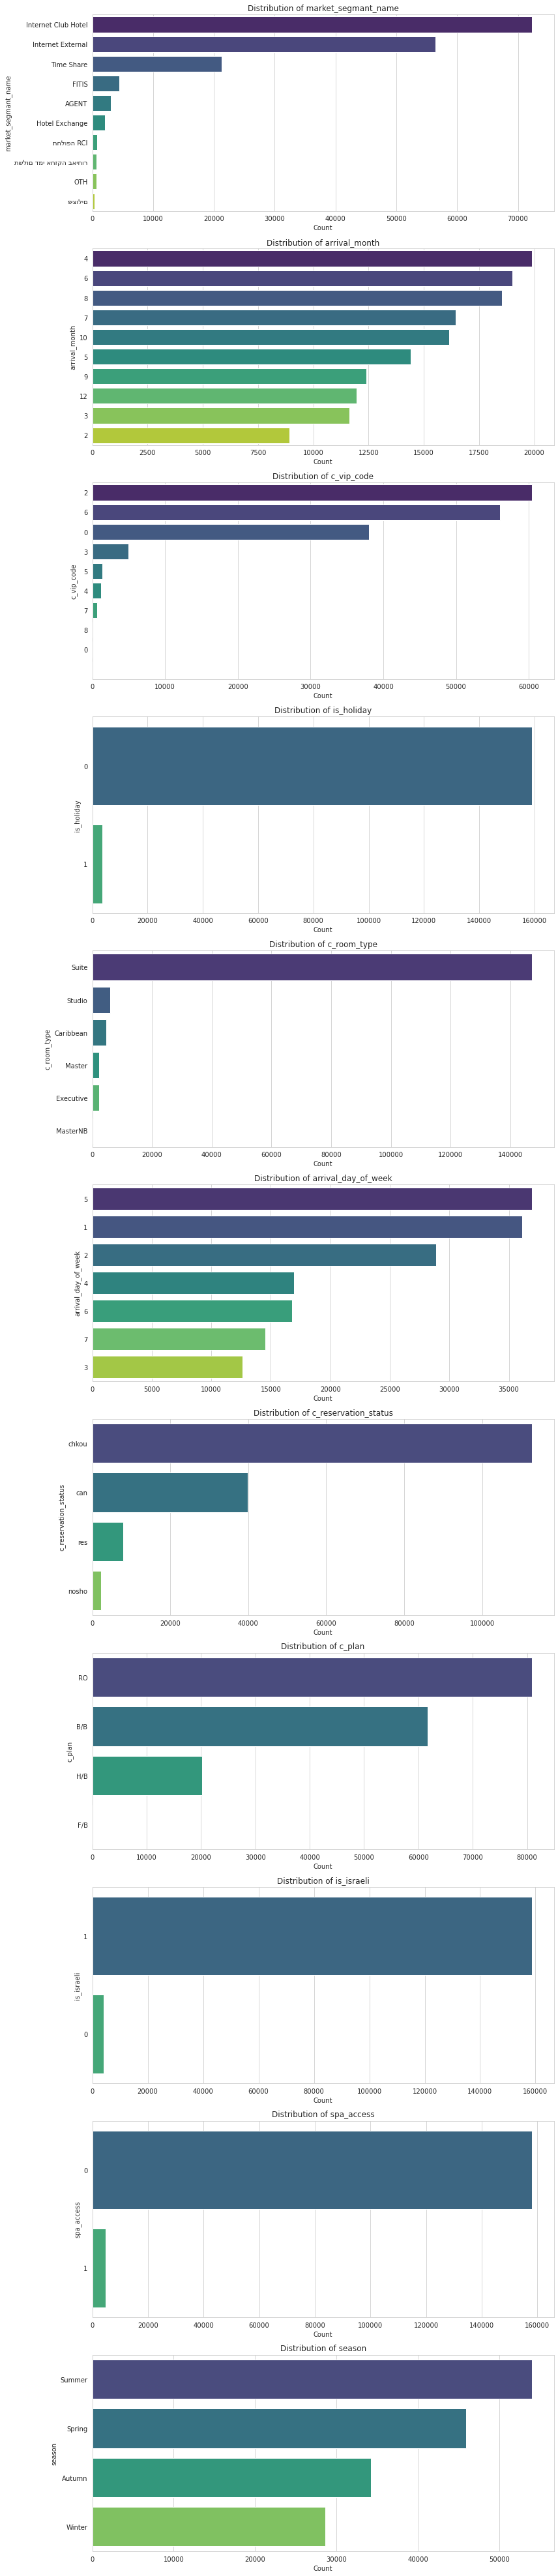

In [49]:
plt.figure(figsize=(12, 5 * len(categorical_columns)))

for i, col in enumerate(categorical_columns, 1):
    plt.subplot(len(categorical_columns), 1, i)
    top_10 = eda_df[col].value_counts().index[:10]  # Get top 10 categories
    sns.countplot(y=eda_df[col], order=top_10, palette="viridis")
    plt.title(f"Distribution of {col}")
    plt.xlabel("Count")

plt.tight_layout()
plt.show()

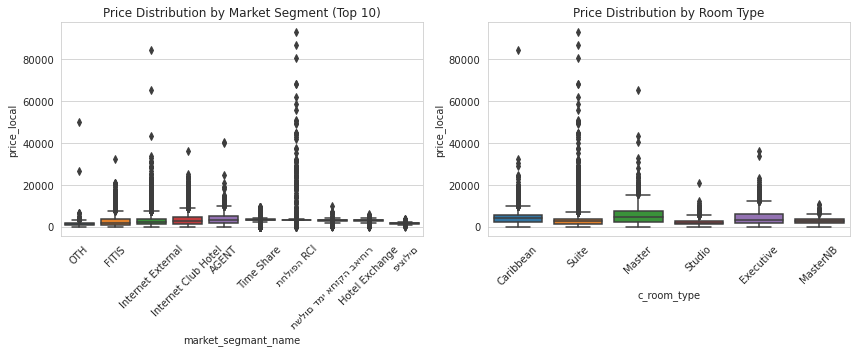

In [50]:
plt.figure(figsize=(12, 5))

# Price vs Market Segment (Top 10)
plt.subplot(1, 2, 1)
top_10_segments = eda_df['market_segmant_name'].value_counts().index[:10]  # Get top 10 market segments
sns.boxplot(x="market_segmant_name", y="price_local", data=eda_df[eda_df['market_segmant_name'].isin(top_10_segments)])
plt.xticks(rotation=45)
plt.title("Price Distribution by Market Segment (Top 10)")

# Price vs Room Type
plt.subplot(1, 2, 2)
sns.boxplot(x="c_room_type", y="price_local", data=eda_df)
plt.xticks(rotation=45)
plt.title("Price Distribution by Room Type")

plt.tight_layout()
plt.show()

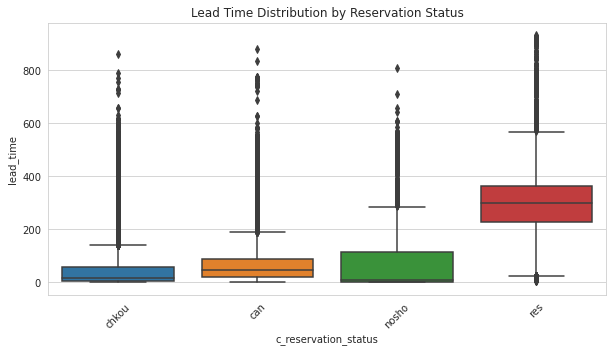

In [51]:
plt.figure(figsize=(10, 5))
sns.boxplot(x="c_reservation_status", y="lead_time", data=eda_df)
plt.title("Lead Time Distribution by Reservation Status")
plt.xticks(rotation=45)
plt.show()

In [52]:
eda_df['c_reservation_status'].value_counts()

chkou    112764
can       39839
res        7972
nosho      2181
Name: c_reservation_status, dtype: int64

In [53]:
# Count the number of rows where 'c_reservation_status' is 'can'
count_can = (eda_df['c_reservation_status'] == 'can').sum()

# Get the total number of rows in the dataset
total_count = len(eda_df)

# Calculate the proportion of rows where 'c_reservation_status' is 'can'
proportion_can = count_can / total_count

# Display the result
print(f"Proportion of rows where 'c_reservation_status' is 'can': {proportion_can:.4f}")


Proportion of rows where 'c_reservation_status' is 'can': 0.2448


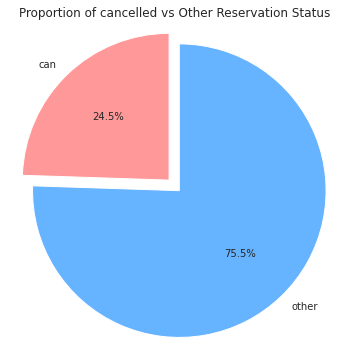

In [54]:

# Count the number of rows where 'c_reservation_status' is 'can'
count_can = (eda_df['c_reservation_status'] == 'can').sum()

# Get the total number of rows in the dataset
total_count = len(eda_df)

# Calculate the proportion of rows where 'c_reservation_status' is 'can'
count_other = total_count - count_can  # Count for all other statuses

# Data for the pie chart
labels = ['can', 'other']
sizes = [count_can, count_other]
colors = ['#ff9999', '#66b3ff']  # Customize colors if desired
explode = (0.1, 0)  # "explode" the 'can' slice slightly

# Create the pie plot
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=explode)
plt.title("Proportion of cancelled vs Other Reservation Status")
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.
plt.show()


### Final Checks

In [55]:
# Print the column names in eda_df
print(eda_df.columns)


Index(['c_reservation_status', 'c_adults', 'c_children', 'c_babies',
       'c_taken_date_time', 'c_room_type', 'c_vip_code', 'c_plan', 'c_nights',
       'price_local', 'rooms', 'guests', 'market_segmant_name', 'lead_time',
       'arrival_month', 'arrival_day_of_week', 'season', 'is_holiday',
       'is_israeli', 'age', 'spa_access'],
      dtype='object')


In [56]:
# Print columns in eda_df categorized by their data type
print("🔹 Numerical Columns:")
print(eda_df.select_dtypes(include=['number']).columns.tolist())

print("\n🔹 Categorical Columns:")
print(eda_df.select_dtypes(include=['object', 'category']).columns.tolist())

🔹 Numerical Columns:
['c_adults', 'c_children', 'c_babies', 'c_nights', 'price_local', 'rooms', 'guests', 'lead_time', 'arrival_month', 'arrival_day_of_week', 'is_holiday', 'is_israeli', 'age', 'spa_access']

🔹 Categorical Columns:
['c_reservation_status', 'c_room_type', 'c_vip_code', 'c_plan', 'market_segmant_name', 'season']


vip_code should be int

In [57]:
# Convert 'c_vip_code' to integer
eda_df["c_vip_code"] = pd.to_numeric(eda_df["c_vip_code"], errors="coerce").fillna(0).astype(int)

# Convert 'arrival_month' and 'arrival_day_of_week' to object type
eda_df["arrival_month"] = eda_df["arrival_month"].astype(str)
eda_df["arrival_day_of_week"] = eda_df["arrival_day_of_week"].astype(str)


In [58]:
print(eda_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162756 entries, 0 to 162755
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   c_reservation_status  162756 non-null  object        
 1   c_adults              162756 non-null  int64         
 2   c_children            162756 non-null  int64         
 3   c_babies              162756 non-null  int64         
 4   c_taken_date_time     162756 non-null  datetime64[ns]
 5   c_room_type           162756 non-null  object        
 6   c_vip_code            162756 non-null  int64         
 7   c_plan                162756 non-null  object        
 8   c_nights              162756 non-null  int64         
 9   price_local           162756 non-null  float64       
 10  rooms                 162756 non-null  float64       
 11  guests                162756 non-null  int64         
 12  market_segmant_name   162756 non-null  object        
 13 

### Entropy based feature selection

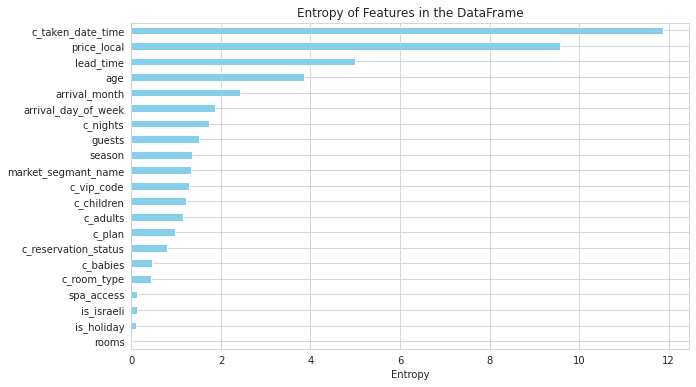

In [59]:

# Assuming eda_df is your dataframe
def calculate_entropy(series):
    value_counts = series.value_counts(normalize=True)
    return entropy(value_counts)

# Calculate entropy for each feature (column)
entropy_values = eda_df.apply(calculate_entropy)

# Plotting the entropy values
plt.figure(figsize=(10, 6))
entropy_values.sort_values().plot(kind='barh', color='skyblue')
plt.xlabel('Entropy')
plt.title('Entropy of Features in the DataFrame')
plt.show()


Let's remove rooms, since almost all of the reservations are for 1 room.

### Data for modeling

We will remove age since most of it is NAs, and guests is adults+children, we wanted to keep those features until this point for our understanding.

In [60]:
# Create a new DataFrame without 'guests' and 'age'
model_df = eda_df.drop(columns=["guests", "age","rooms"])


## Clustering

We need the date of reservation only for the classification, and we will use season only, since we dont want to make a dummy for each month.

In [61]:
clustering_df = model_df.drop(columns=["c_taken_date_time","arrival_month"])

### Normalize

In [62]:

# List of categorical columns (that should not be scaled)
categorical_columns = [
    'c_reservation_status',
    'c_room_type',
    'c_plan',
    'market_segmant_name',
    'season',
    'arrival_day_of_week',
    'is_israeli',
    'spa_access',
    'is_holiday'
]

# Identify the continuous columns (everything except the categorical ones)
continuous_columns = [col for col in clustering_df.columns if col not in categorical_columns]

# Apply RobustScaler to only the continuous columns
scaler = RobustScaler()
clustering_df[continuous_columns] = scaler.fit_transform(clustering_df[continuous_columns])


In [63]:
clustering_df.head()

,c_reservation_status,c_adults,c_children,c_babies,c_room_type,c_vip_code,c_plan,c_nights,price_local,market_segmant_name,lead_time,arrival_day_of_week,season,is_holiday,is_israeli,spa_access
0,chkou,1.0,0.5,0.0,Caribbean,0.75,B/B,-0.5,-0.700004,OTH,-0.316456,1,Winter,0,1,0
1,chkou,0.0,0.0,0.0,Suite,-0.50,RO,0.0,-0.699160,FITIS,-0.316456,1,Winter,0,1,0
2,chkou,0.0,0.0,0.0,Suite,-0.50,RO,0.0,-0.699160,FITIS,-0.316456,1,Winter,0,1,0
3,chkou,2.0,0.0,0.0,Suite,-0.50,B/B,-1.0,-0.960874,Internet External,-0.303797,5,Winter,0,1,0
4,chkou,0.0,1.0,0.0,Suite,-0.50,RO,0.0,-0.648506,FITIS,-0.316456,2,Spring,0,1,0


### Create dummies:

market_segmant_name has too many values let's deal with it

In [64]:
clustering_df['market_segmant_name'].value_counts()

Internet Club Hotel           72280
Internet External             56409
Time Share                    21242
FITIS                          4479
AGENT                          3002
Hotel Exchange                 2104
תחלופה RCI                      793
תשלום דמי אחזקה באיחור          724
OTH                             717
פיצולים                         412
תחלופה קלאב אין                 163
נופשונים                        105
מבצע מיוחד                       99
INTERNET                         83
BARTER FITS                      60
TSVL תחלופה אינטרוול             38
Booking                          30
בודדים בהנחה                      4
OTHERS                            3
Israeli FIT - Room only           3
תחלופה קלאב הוטל אילת             2
שבוע מקורי קלאב הוטל טבריה        1
GROUP TOURIST                     1
Room Move                         1
Yayasoft                          1
Name: market_segmant_name, dtype: int64

In [65]:
# Get the top 6 most frequent values in 'market_segmant_name'
top_6_values = clustering_df['market_segmant_name'].value_counts().nlargest(6).index

# Replace values that are not in the top 6 with 'Other'
clustering_df['market_segmant_name'] = clustering_df['market_segmant_name'].apply(
    lambda x: x if x in top_6_values else 'Other'
)


In [66]:
# Assuming clustering_df is your dataframe
clustering_df = pd.get_dummies(clustering_df, columns=[
    'c_reservation_status',
    'c_room_type',
    'c_plan',
    'market_segmant_name',
    'season',
    'arrival_day_of_week'
])


In [67]:
clustering_df.head()

,c_adults,c_children,c_babies,c_vip_code,c_nights,price_local,lead_time,is_holiday,is_israeli,spa_access,c_reservation_status_can,c_reservation_status_chkou,c_reservation_status_nosho,c_reservation_status_res,c_room_type_Caribbean,c_room_type_Executive,c_room_type_Master,c_room_type_MasterNB,c_room_type_Studio,c_room_type_Suite,c_plan_B/B,c_plan_F/B,c_plan_H/B,c_plan_RO,market_segmant_name_AGENT,market_segmant_name_FITIS,market_segmant_name_Hotel Exchange,market_segmant_name_Internet Club Hotel,market_segmant_name_Internet External,market_segmant_name_Other,market_segmant_name_Time Share,season_Autumn,season_Spring,season_Summer,season_Winter,arrival_day_of_week_1,arrival_day_of_week_2,arrival_day_of_week_3,arrival_day_of_week_4,arrival_day_of_week_5,arrival_day_of_week_6,arrival_day_of_week_7
0,1.0,0.5,0.0,0.75,-0.5,-0.700004,-0.316456,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0
1,0.0,0.0,0.0,-0.50,0.0,-0.699160,-0.316456,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
2,0.0,0.0,0.0,-0.50,0.0,-0.699160,-0.316456,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
3,2.0,0.0,0.0,-0.50,-1.0,-0.960874,-0.303797,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0
4,0.0,1.0,0.0,-0.50,0.0,-0.648506,-0.316456,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0


## Efficient Clustering With Spark: 

Creating a Spark dataframe, parallelizes the data by converting clustering_df into a distributed Spark DataFrame using RDDs (under the hood).

In [68]:
spark_df = spark.createDataFrame(clustering_df)


In [69]:
feature_cols = list(clustering_df.columns)  # Convert Index to list of strings
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")


In [70]:
vectorized_df = vector_assembler.transform(spark_df)


Let's look for the best number of clusters:

In [71]:
spark.sparkContext.setLogLevel("ERROR")


In [72]:
# ✅ Collect features as NumPy array for metrics
features_np = np.vstack(vectorized_df.select("features").rdd.flatMap(lambda x: x).collect())

# ✅ Define range for k (number of clusters)
k_range = range(2, 9)  # Trying k from 2 to 8

# ✅ Store evaluation metrics
wssse_scores = []
silhouette_scores = []
db_scores = []
ch_scores = []

for k in k_range:
    print(k)
    kmeans = KMeans(featuresCol="features", k=k)
    model = kmeans.fit(vectorized_df)
    
    # WSSSE (Elbow Method)
    wssse = model.summary.trainingCost
    wssse_scores.append(wssse)
    
    # Predictions
    predictions = model.transform(vectorized_df)
    cluster_labels = np.array(predictions.select("prediction").rdd.flatMap(lambda x: x).collect())

    # Compute Metrics
    silhouette = silhouette_score(features_np, cluster_labels)
    db_index = davies_bouldin_score(features_np, cluster_labels)
    ch_index = calinski_harabasz_score(features_np, cluster_labels)

    silhouette_scores.append(silhouette)
    db_scores.append(db_index)
    ch_scores.append(ch_index)


2


3


4


5


6


7


8


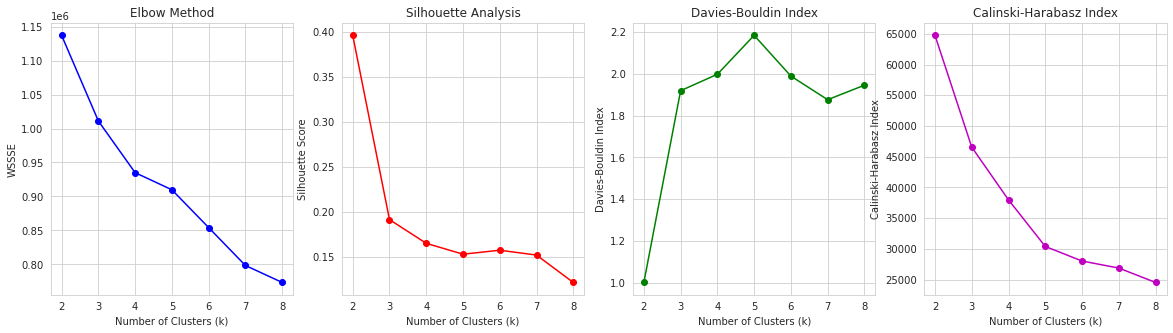

In [73]:
# ✅ Plot the results
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Elbow Method (WSSSE)
axes[0].plot(k_range, wssse_scores, 'bo-')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('WSSSE')
axes[0].set_title('Elbow Method')

# Silhouette Score
axes[1].plot(k_range, silhouette_scores, 'ro-')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Analysis')

# Davies-Bouldin Index
axes[2].plot(k_range, db_scores, 'go-')
axes[2].set_xlabel('Number of Clusters (k)')
axes[2].set_ylabel('Davies-Bouldin Index')
axes[2].set_title('Davies-Bouldin Index')

# Calinski-Harabasz Index
axes[3].plot(k_range, ch_scores, 'mo-')
axes[3].set_xlabel('Number of Clusters (k)')
axes[3].set_ylabel('Calinski-Harabasz Index')
axes[3].set_title('Calinski-Harabasz Index')

plt.show()

In [74]:
kmeans = KMeans(featuresCol="features", k=4)
final_model = kmeans.fit(vectorized_df)
predictions = final_model.transform(vectorized_df)

In [75]:
# Get cluster centers as a DataFrame for better visualization
cluster_centers_df = pd.DataFrame(final_model.clusterCenters(), columns=clustering_df.columns)
cluster_centers_df.index.name = "Cluster"
cluster_centers_df.reset_index(inplace=True)


In [76]:
# Denormalize only the continuous columns
cluster_centers_df[continuous_columns] = (
    cluster_centers_df[continuous_columns] * scaler.scale_ + scaler.center_
)

In [77]:
cluster_centers_df

,Cluster,c_adults,c_children,c_babies,c_vip_code,c_nights,price_local,lead_time,is_holiday,is_israeli,spa_access,c_reservation_status_can,c_reservation_status_chkou,c_reservation_status_nosho,c_reservation_status_res,c_room_type_Caribbean,c_room_type_Executive,c_room_type_Master,c_room_type_MasterNB,c_room_type_Studio,c_room_type_Suite,c_plan_B/B,c_plan_F/B,c_plan_H/B,c_plan_RO,market_segmant_name_AGENT,market_segmant_name_FITIS,market_segmant_name_Hotel Exchange,market_segmant_name_Internet Club Hotel,market_segmant_name_Internet External,market_segmant_name_Other,market_segmant_name_Time Share,season_Autumn,season_Spring,season_Summer,season_Winter,arrival_day_of_week_1,arrival_day_of_week_2,arrival_day_of_week_3,arrival_day_of_week_4,arrival_day_of_week_5,arrival_day_of_week_6,arrival_day_of_week_7
0,0,2.311916,0.907737,0.186086,1.717278,2.158093,1961.399558,22.007050,0.028490,0.997633,0.023413,0.157733,0.822439,0.011492,0.008336,0.020017,0.011904,0.009365,0.001441,0.026689,0.930584,0.503679,0.000652,0.130838,0.364831,0.034099,0.050342,0.004460,0.877875,0.000875,0.026329,0.006020,0.236617,0.327610,0.205022,0.230751,0.166687,0.089793,0.092091,0.115418,0.283511,0.132330,0.120169
1,1,3.873548,0.362419,0.059932,0.116062,6.552730,3132.964065,316.747265,0.003379,0.999493,0.043671,0.085442,0.608608,0.018077,0.287874,0.046585,0.001183,0.003337,0.002956,0.024834,0.921105,0.027030,0.000042,0.010348,0.962580,0.000169,0.001478,0.068590,0.001014,0.000549,0.052963,0.875238,0.221185,0.205516,0.494531,0.078768,0.187946,0.700680,0.039405,0.023272,0.032394,0.003801,0.012502
2,2,2.464166,1.559079,0.240394,2.994971,3.743936,6271.528258,67.234904,0.017511,0.980650,0.037352,0.400687,0.585360,0.005029,0.008924,0.042473,0.022080,0.035052,0.001411,0.010273,0.888712,0.484958,0.000276,0.293324,0.221442,0.029930,0.032905,0.006593,0.644975,0.272532,0.007943,0.005121,0.158453,0.189764,0.611825,0.039958,0.411696,0.088503,0.065718,0.141065,0.181024,0.067405,0.044589
3,3,2.311383,0.682202,0.111960,5.979406,2.198489,2049.095564,25.690050,0.029210,0.931740,0.023501,0.322905,0.650148,0.019079,0.007868,0.020926,0.016484,0.010401,0.001246,0.074841,0.876103,0.328863,0.000042,0.056592,0.614503,0.000706,0.009051,0.000104,0.000893,0.985239,0.003986,0.000021,0.208786,0.327347,0.215533,0.248334,0.176441,0.087193,0.086570,0.104860,0.285059,0.140194,0.119683


### PCA for Plotting

In [78]:

# ✅ Apply PCA (Reduce to 2D for visualization)
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(vectorized_df)
data_pca = pca_model.transform(vectorized_df)

# ✅ Add cluster assignments from previous clustering step
data_pca = data_pca.join(predictions.select("features", "prediction"), on="features")

# ✅ Convert to Pandas DataFrame for plotting
pandas_df = data_pca.select("pca_features", "prediction").toPandas()
pandas_df["PCA1"] = pandas_df["pca_features"].apply(lambda x: x[0])  # Extract first component
pandas_df["PCA2"] = pandas_df["pca_features"].apply(lambda x: x[1])  # Extract second component
pandas_df["Cluster"] = pandas_df["prediction"]  # Keep original cluster labels



/tmp/ipykernel_38032/3635266347.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label="Cluster ID")


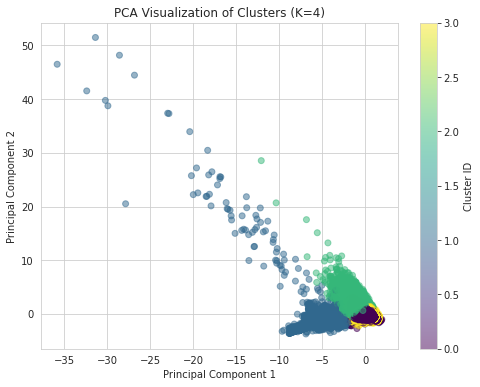

In [79]:
# ✅ Plot the clusters
plt.figure(figsize=(8,6))
plt.scatter(pandas_df["PCA1"], pandas_df["PCA2"], c=pandas_df["Cluster"], cmap='viridis', alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title(f"PCA Visualization of Clusters (K=4)")
plt.colorbar(label="Cluster ID")
plt.show()

### Cluster ID for classification

We can see that the cancellation rates are different for each cluster, let's make another model without this feature so we could use the IDs as an extra feature cor classifying cancellation (we don't want data leakage).

In [80]:
clustering_df_for_classifier =  clustering_df.drop(columns=["c_reservation_status_can", "c_reservation_status_chkou", "c_reservation_status_nosho", "c_reservation_status_res"])

In [81]:
spark_df_no_cancellation = spark.createDataFrame(clustering_df_for_classifier)


In [82]:
feature_cols = list(clustering_df_for_classifier.columns)  # Convert Index to list of strings
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")


In [83]:
vectorized_df = vector_assembler.transform(spark_df_no_cancellation)


In [84]:
kmeans = KMeans(featuresCol="features", k=4)
final_model = kmeans.fit(vectorized_df)
predictions = final_model.transform(vectorized_df)

In [85]:
# Get cluster centers as a DataFrame for better visualization
cluster_centers_df = pd.DataFrame(final_model.clusterCenters(), columns=clustering_df_for_classifier.columns)
cluster_centers_df.index.name = "Cluster"
cluster_centers_df.reset_index(inplace=True)


In [86]:
# Denormalize only the continuous columns
cluster_centers_df[continuous_columns] = (
    cluster_centers_df[continuous_columns] * scaler.scale_ + scaler.center_
)

In [87]:
cluster_centers_df

,Cluster,c_adults,c_children,c_babies,c_vip_code,c_nights,price_local,lead_time,is_holiday,is_israeli,spa_access,c_room_type_Caribbean,c_room_type_Executive,c_room_type_Master,c_room_type_MasterNB,c_room_type_Studio,c_room_type_Suite,c_plan_B/B,c_plan_F/B,c_plan_H/B,c_plan_RO,market_segmant_name_AGENT,market_segmant_name_FITIS,market_segmant_name_Hotel Exchange,market_segmant_name_Internet Club Hotel,market_segmant_name_Internet External,market_segmant_name_Other,market_segmant_name_Time Share,season_Autumn,season_Spring,season_Summer,season_Winter,arrival_day_of_week_1,arrival_day_of_week_2,arrival_day_of_week_3,arrival_day_of_week_4,arrival_day_of_week_5,arrival_day_of_week_6,arrival_day_of_week_7
0,0,2.468799,1.559327,0.239816,2.973650,3.751798,6272.218908,66.266106,0.017965,0.980842,0.038959,0.043030,0.022372,0.035226,0.001469,0.010222,0.887682,0.485998,0.000275,0.296067,0.217659,0.029992,0.033849,0.007467,0.646641,0.267207,0.009304,0.005539,0.160214,0.190482,0.609304,0.040000,0.410620,0.089518,0.065922,0.140566,0.181362,0.067452,0.044560
1,1,2.310644,0.905611,0.187001,1.704665,2.148185,1951.128129,22.311041,0.028322,0.997618,0.022143,0.018864,0.011218,0.009147,0.001432,0.026682,0.932656,0.503754,0.000656,0.127267,0.368323,0.034121,0.049136,0.004039,0.881328,0.000880,0.024698,0.005799,0.235412,0.328179,0.204984,0.231425,0.166549,0.089039,0.092145,0.115428,0.283409,0.132859,0.120571
2,2,2.309641,0.685056,0.111618,5.980565,2.203594,2054.580870,25.896387,0.029111,0.932060,0.023892,0.021911,0.017062,0.010502,0.001217,0.074604,0.874703,0.329118,0.000041,0.059234,0.611607,0.000846,0.010233,0.000186,0.001217,0.982339,0.005137,0.000041,0.209288,0.326621,0.216489,0.247602,0.176835,0.087437,0.086426,0.105181,0.285193,0.139636,0.119293
3,3,3.873812,0.362342,0.059947,0.116007,6.551857,3133.088887,316.819906,0.003380,0.999493,0.043724,0.046555,0.001183,0.003337,0.002957,0.024841,0.921127,0.027037,0.000042,0.010350,0.962570,0.000169,0.001267,0.068311,0.001141,0.000591,0.053061,0.875459,0.221241,0.204977,0.494952,0.078831,0.188163,0.700815,0.039415,0.023320,0.032107,0.003633,0.012547


Add the cluster ID to the original data:

In [88]:
# ✅ Select the cluster predictions and original features
predictions_df = predictions.select("features", "prediction")

# ✅ Convert Spark DataFrame to Pandas
predictions_pd = predictions_df.select("prediction").toPandas()

# ✅ Add cluster predictions as a new column in original Pandas DataFrame
model_df["Cluster_Prediction"] = predictions_pd["prediction"]

# ✅ Show the updated DataFrame
print(model_df.head())


  c_reservation_status  c_adults  c_children  c_babies   c_taken_date_time  \
0                chkou         3           1         0 2022-02-06 18:39:07   
1                chkou         2           0         0 2022-02-13 09:27:10   
2                chkou         2           0         0 2022-02-13 09:27:10   
3                chkou         4           0         0 2022-02-23 13:18:50   
4                chkou         2           2         0 2022-03-14 21:18:36   

  c_room_type  c_vip_code c_plan  c_nights  price_local market_segmant_name  \
0   Caribbean           5    B/B         2       1018.0                 OTH   
1       Suite           0     RO         3       1020.0               FITIS   
2       Suite           0     RO         3       1020.0               FITIS   
3       Suite           0    B/B         1        400.0   Internet External   
4       Suite           0     RO         3       1140.0               FITIS   

   lead_time arrival_month arrival_day_of_week  season  

## Classification

### Fix the data for classification

In [89]:
# Count the number of rows before removal
rows_before = len(model_df)

# Remove rows where 'c_reservation_status' is 'res'
model_df = model_df[model_df["c_reservation_status"] != "res"].reset_index(drop=True)

# Count the number of rows after removal
rows_after = len(model_df)

# Calculate the number of rows removed
rows_removed = rows_before - rows_after

# Print the number of removed rows
print(f"Rows removed: {rows_removed}")


Rows removed: 7972


In [90]:
# Create the y label based on 'c_reservation_status'
model_df["y_label"] = (model_df["c_reservation_status"] == "can").astype(int)

In [91]:
model_df = model_df.drop(columns=["c_reservation_status"])

In [92]:
model_df.columns

Index(['c_adults', 'c_children', 'c_babies', 'c_taken_date_time',
       'c_room_type', 'c_vip_code', 'c_plan', 'c_nights', 'price_local',
       'market_segmant_name', 'lead_time', 'arrival_month',
       'arrival_day_of_week', 'season', 'is_holiday', 'is_israeli',
       'spa_access', 'Cluster_Prediction', 'y_label'],
      dtype='object')

In [93]:
# ✅ Compute split indices for 80-10-10
train_idx = int(len(model_df) * 0.8)  # First 80%
val_idx = int(len(model_df) * 0.9)    # Next 10% (80%-90%)

# ✅ Create train, validation, and test sets
train_df = model_df.iloc[:train_idx]        # 80%
val_df = model_df.iloc[train_idx:val_idx]   # 10%
test_df = model_df.iloc[val_idx:]           # 10%

# ✅ Print dataset sizes
print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 123827, Validation size: 15478, Test size: 15479


In [94]:
# ✅ Define features (X) and target variable (y) for training, validation, and testing
X_train = train_df.drop(columns=["y_label", "c_taken_date_time",'arrival_month'])
y_train = train_df["y_label"]

X_val = val_df.drop(columns=["y_label", "c_taken_date_time",'arrival_month'])
y_val = val_df["y_label"]

X_test = test_df.drop(columns=["y_label", "c_taken_date_time",'arrival_month'])
y_test = test_df["y_label"]

# ✅ Print shapes to confirm
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (123827, 16), y_train shape: (123827,)
X_val shape: (15478, 16), y_val shape: (15478,)
X_test shape: (15479, 16), y_test shape: (15479,)


## Spark

In [95]:
train = train_df.copy()
val = val_df.copy()
test = test_df.copy()

# Use `.loc[:, "column_name"]` to avoid warnings
train.loc[:, "y_label"] = y_train
val.loc[:, "y_label"] = y_val
test.loc[:, "y_label"] = y_test

# ✅ Convert Pandas DataFrames to PySpark DataFrames
train_spark_df = spark.createDataFrame(train)
val_spark_df = spark.createDataFrame(val)
test_spark_df = spark.createDataFrame(test)

In [96]:
# Define feature columns (excluding target and timestamp)
feature_columns = [col for col in train_spark_df.columns if col not in ["y_label", "c_taken_date_time",'arrival_month']]

# Extract Features (X) and Labels (y)
X_train_spark = train_spark_df.select(feature_columns)
y_train_spark = train_spark_df.select("y_label")

X_val_spark = val_spark_df.select(feature_columns)
y_val_spark = val_spark_df.select("y_label")


X_test_spark = test_spark_df.select(feature_columns)
y_test_spark = test_spark_df.select("y_label")


In [97]:
categorical_columns = ["c_room_type", "c_plan", "market_segmant_name", "season", "arrival_day_of_week",'Cluster_Prediction']


In [98]:

# Convert categorical variables to numeric indices
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep") for col in categorical_columns]

# One-Hot Encoding
encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_ohe") for col in categorical_columns]


In [99]:

# Combine categorical OHE columns + numeric columns
feature_cols = [col+"_ohe" for col in categorical_columns] + [col for col in feature_columns if col not in categorical_columns]

# Assemble features into a single column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")


In [100]:

rf = RandomForestClassifier(labelCol="y_label", featuresCol="features", numTrees=100, maxDepth=10)


In [101]:


pipeline = Pipeline(stages=indexers + encoders + [assembler, rf])
rf_model = pipeline.fit(train_spark_df)


In [102]:
predictions = rf_model.transform(val_spark_df)
predictions.select("y_label", "prediction", "probability").show(truncate=False)


+-------+----------+----------------------------------------+
|y_label|prediction|probability                             |
+-------+----------+----------------------------------------+
|1      |0.0       |[0.7037543451723056,0.2962456548276945] |
|0      |0.0       |[0.896006805523129,0.10399319447687097] |
|0      |0.0       |[0.868546318767703,0.13145368123229695] |
|0      |0.0       |[0.7076177194976446,0.29238228050235526]|
|0      |0.0       |[0.8899286517907206,0.11007134820927948]|
|0      |0.0       |[0.8123842646317243,0.1876157353682758] |
|0      |0.0       |[0.8726062120369862,0.12739378796301384]|
|0      |0.0       |[0.7916615402344893,0.2083384597655107] |
|1      |0.0       |[0.6028159654598975,0.3971840345401025] |
|0      |0.0       |[0.6507209198768282,0.3492790801231718] |
|0      |0.0       |[0.8737380398413185,0.12626196015868152]|
|0      |0.0       |[0.9190961163903556,0.08090388360964439]|
|0      |0.0       |[0.8030478218204558,0.1969521781795442] |
|1      

In [103]:

# AUC-ROC
evaluator = BinaryClassificationEvaluator(labelCol="y_label", rawPredictionCol="prediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)

# Accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="y_label", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)

# Print results
print(f"Validation AUC-ROC: {auc:.2f}")
print(f"Validation Accuracy: {accuracy:.2f}")


Validation AUC-ROC: 0.66
Validation Accuracy: 0.80


In [104]:

# Compute Confusion Matrix
cm = predictions.groupBy("y_label", "prediction").count().orderBy(["y_label", "prediction"])
cm.show()

# Convert to Pandas for readability
cm_pandas = cm.toPandas().pivot(index="y_label", columns="prediction", values="count").fillna(0)
print("\nConfusion Matrix:\n", cm_pandas)


+-------+----------+-----+
|y_label|prediction|count|
+-------+----------+-----+
|      0|       0.0|11004|
|      0|       1.0|  844|
|      1|       0.0| 2237|
|      1|       1.0| 1393|
+-------+----------+-----+




Confusion Matrix:
 prediction    0.0   1.0
y_label                
0           11004   844
1            2237  1393


In [105]:

# ✅ Define hyperparameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [50,75, 100])
             .addGrid(rf.maxDepth, [5,7, 9])
             .addGrid(rf.minInstancesPerNode, [3, 7])
             .build())

# ✅ Define evaluators
auc_evaluator = BinaryClassificationEvaluator(labelCol="y_label", metricName="areaUnderROC")
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="y_label", metricName="accuracy")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="y_label", metricName="f1")

# ✅ Store the best model and best AUC score
best_model = None
best_auc = float("-inf")
best_params = None
best_accuracy = None
best_f1 = None

# ✅ Iterate over each hyperparameter combination
for params in paramGrid:
    # Create a new pipeline with current hyperparameters
    pipeline_rf = pipeline.copy(params)
    
    # Train the model on train_spark_df
    rf_model = pipeline_rf.fit(train_spark_df)
    
    # Make predictions on validation set
    val_predictions = rf_model.transform(val_spark_df)
    
    # Evaluate metrics
    auc = auc_evaluator.evaluate(val_predictions)
    accuracy = accuracy_evaluator.evaluate(val_predictions)
    f1_score = f1_evaluator.evaluate(val_predictions)
    
    print(f"Params: {params}, AUC-ROC: {auc}, Accuracy: {accuracy}, F1-score: {f1_score}")
    
    # Update best model if AUC improves
    if auc > best_auc:
        best_auc = auc
        best_model = rf_model
        best_params = params
        best_accuracy = accuracy
        best_f1 = f1_score

# ✅ Print the best model's performance
print(f"Best Validation AUC-ROC: {best_auc}")
print(f"Best Validation Accuracy: {best_accuracy}")
print(f"Best Validation F1-score: {best_f1}")
print(f"Best Parameters: {best_params}")


Params: {Param(parent='RandomForestClassifier_b414643f2143', name='numTrees', doc='Number of trees to train (>= 1).'): 50, Param(parent='RandomForestClassifier_b414643f2143', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5, Param(parent='RandomForestClassifier_b414643f2143', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 3}, AUC-ROC: 0.7772200978231146, Accuracy: 0.784855924538054, F1-score: 0.7325709032846869


Params: {Param(parent='RandomForestClassifier_b414643f2143', name='numTrees', doc='Number of trees to train (>= 1).'): 50, Param(parent='RandomForestClassifier_b414643f2143', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5, Param(parent='RandomForestClassifier_b414643f2143', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 7}, AUC-ROC: 0.7753491540225782, Accuracy: 0.7838221992505492, F1-score: 0.7322275748928441


Params: {Param(parent='RandomForestClassifier_b414643f2143', name='numTrees', doc='Number of trees to train (>= 1).'): 50, Param(parent='RandomForestClassifier_b414643f2143', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 7, Param(parent='RandomForestClassifier_b414643f2143', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 3}, AUC-ROC: 0.7925318264593016, Accuracy: 0.7976482749709265, F1-score: 0.7693378124580468


Params: {Param(parent='RandomForestClassifier_b414643f2143', name='numTrees', doc='Number of trees to train (>= 1).'): 50, Param(parent='RandomForestClassifier_b414643f2143', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 7, Param(parent='RandomForestClassifier_b414643f2143', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 7}, AUC-ROC: 0.7907187552896839, Accuracy: 0.7979713141232717, F1-score: 0.769945841484715


Params: {Param(parent='RandomForestClassifier_b414643f2143', name='numTrees', doc='Number of trees to train (>= 1).'): 50, Param(parent='RandomForestClassifier_b414643f2143', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 9, Param(parent='RandomForestClassifier_b414643f2143', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 3}, AUC-ROC: 0.803065900859928, Accuracy: 0.7997803333764052, F1-score: 0.7786585397290678


Params: {Param(parent='RandomForestClassifier_b414643f2143', name='numTrees', doc='Number of trees to train (>= 1).'): 50, Param(parent='RandomForestClassifier_b414643f2143', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 9, Param(parent='RandomForestClassifier_b414643f2143', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 7}, AUC-ROC: 0.8010909886105547, Accuracy: 0.8001679803592195, F1-score: 0.7801146422941357


Params: {Param(parent='RandomForestClassifier_b414643f2143', name='numTrees', doc='Number of trees to train (>= 1).'): 75, Param(parent='RandomForestClassifier_b414643f2143', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5, Param(parent='RandomForestClassifier_b414643f2143', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 3}, AUC-ROC: 0.7775661710407122, Accuracy: 0.783692983589611, F1-score: 0.7311253405997392


Params: {Param(parent='RandomForestClassifier_b414643f2143', name='numTrees', doc='Number of trees to train (>= 1).'): 75, Param(parent='RandomForestClassifier_b414643f2143', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5, Param(parent='RandomForestClassifier_b414643f2143', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 7}, AUC-ROC: 0.774745653391071, Accuracy: 0.783628375759142, F1-score: 0.7305347659978723


Params: {Param(parent='RandomForestClassifier_b414643f2143', name='numTrees', doc='Number of trees to train (>= 1).'): 75, Param(parent='RandomForestClassifier_b414643f2143', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 7, Param(parent='RandomForestClassifier_b414643f2143', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 3}, AUC-ROC: 0.7935599666482518, Accuracy: 0.7965499418529526, F1-score: 0.7721959082432466


Params: {Param(parent='RandomForestClassifier_b414643f2143', name='numTrees', doc='Number of trees to train (>= 1).'): 75, Param(parent='RandomForestClassifier_b414643f2143', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 7, Param(parent='RandomForestClassifier_b414643f2143', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 7}, AUC-ROC: 0.793374978841264, Accuracy: 0.7979713141232717, F1-score: 0.7683545622952496


Params: {Param(parent='RandomForestClassifier_b414643f2143', name='numTrees', doc='Number of trees to train (>= 1).'): 75, Param(parent='RandomForestClassifier_b414643f2143', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 9, Param(parent='RandomForestClassifier_b414643f2143', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 3}, AUC-ROC: 0.8020204732860493, Accuracy: 0.8004910195115648, F1-score: 0.7823967637479795


Params: {Param(parent='RandomForestClassifier_b414643f2143', name='numTrees', doc='Number of trees to train (>= 1).'): 75, Param(parent='RandomForestClassifier_b414643f2143', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 9, Param(parent='RandomForestClassifier_b414643f2143', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 7}, AUC-ROC: 0.8027814669933019, Accuracy: 0.8006848430029719, F1-score: 0.780465849917328


Params: {Param(parent='RandomForestClassifier_b414643f2143', name='numTrees', doc='Number of trees to train (>= 1).'): 100, Param(parent='RandomForestClassifier_b414643f2143', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5, Param(parent='RandomForestClassifier_b414643f2143', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 3}, AUC-ROC: 0.7750047200257442, Accuracy: 0.784855924538054, F1-score: 0.7327728023845875


Params: {Param(parent='RandomForestClassifier_b414643f2143', name='numTrees', doc='Number of trees to train (>= 1).'): 100, Param(parent='RandomForestClassifier_b414643f2143', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5, Param(parent='RandomForestClassifier_b414643f2143', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 7}, AUC-ROC: 0.7721686239660123, Accuracy: 0.7828530817935134, F1-score: 0.7286725497093185


Params: {Param(parent='RandomForestClassifier_b414643f2143', name='numTrees', doc='Number of trees to train (>= 1).'): 100, Param(parent='RandomForestClassifier_b414643f2143', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 7, Param(parent='RandomForestClassifier_b414643f2143', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 3}, AUC-ROC: 0.7907176624758419, Accuracy: 0.7978420984623337, F1-score: 0.7710869242138293


Params: {Param(parent='RandomForestClassifier_b414643f2143', name='numTrees', doc='Number of trees to train (>= 1).'): 100, Param(parent='RandomForestClassifier_b414643f2143', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 7, Param(parent='RandomForestClassifier_b414643f2143', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 7}, AUC-ROC: 0.7911203643766869, Accuracy: 0.7986173924279623, F1-score: 0.7702460696124437


Params: {Param(parent='RandomForestClassifier_b414643f2143', name='numTrees', doc='Number of trees to train (>= 1).'): 100, Param(parent='RandomForestClassifier_b414643f2143', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 9, Param(parent='RandomForestClassifier_b414643f2143', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 3}, AUC-ROC: 0.8024924526090814, Accuracy: 0.8021708231037602, F1-score: 0.7823005235328373


Params: {Param(parent='RandomForestClassifier_b414643f2143', name='numTrees', doc='Number of trees to train (>= 1).'): 100, Param(parent='RandomForestClassifier_b414643f2143', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 9, Param(parent='RandomForestClassifier_b414643f2143', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 7}, AUC-ROC: 0.8016674014095904, Accuracy: 0.8008140586639101, F1-score: 0.7806081735154365
Best Validation AUC-ROC: 0.803065900859928
Best Validation Accuracy: 0.7997803333764052
Best Validation F1-score: 0.7786585397290678
Best Parameters: {Param(parent='RandomForestClassifier_b414643f2143', name='numTrees', doc='Number of trees to train (>= 1).'): 50, Param(parent

The best parameters if we look at all 3 metrics are: numTrees=100, maxDepth=9, minInstancesPerNode=3

### Train the model with the best Hyperparameters on train+validation

In [106]:
#  Merge Train and Validation datasets
train_val_spark_df = train_spark_df.union(val_spark_df)

#  Define categorical columns for encoding
categorical_columns = ["c_room_type", "c_plan", "market_segmant_name", "season", "arrival_day_of_week", "Cluster_Prediction"]

#  Define feature columns (excluding target and timestamp)
feature_columns = [col for col in train_val_spark_df.columns if col not in ["y_label", "c_taken_date_time", "arrival_month"]]

#  Convert categorical variables to numeric indices
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep") for col in categorical_columns]

#  One-Hot Encoding for categorical variables
encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_ohe") for col in categorical_columns]

#  Assemble categorical OHE columns + numeric columns into a single feature vector
feature_cols = [col+"_ohe" for col in categorical_columns] + [col for col in feature_columns if col not in categorical_columns]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

#  Define the final RandomForest model with best hyperparameters
final_rf = RandomForestClassifier(
    labelCol="y_label",
    featuresCol="features",
    numTrees=100,  # Best number of trees
    maxDepth=9,  # Best max depth
    minInstancesPerNode=3  # Best min instances per node
)

#  Create a pipeline (same as before)
pipeline = Pipeline(stages=indexers + encoders + [assembler, final_rf])

#  Train the model on Train + Validation dataset
final_model = pipeline.fit(train_val_spark_df)

print("✅ Final Random Forest Model trained on Train + Validation!")




✅ Final Random Forest Model trained on Train + Validation!


### Real-time analysis with Kafka on the test:

In [107]:
# Save test Spark DataFrame to CSV
test_spark_df.write.option("header", True).mode("overwrite").csv("test_data_for_kafka")

In [108]:
test_spark_df.count()


15479

In [109]:
for col in test_spark_df.columns:
    print(col)


c_adults
c_children
c_babies
c_taken_date_time
c_room_type
c_vip_code
c_plan
c_nights
price_local
market_segmant_name
lead_time
arrival_month
arrival_day_of_week
season
is_holiday
is_israeli
spa_access
Cluster_Prediction
y_label


In [110]:

schema = StructType([
    StructField("c_adults", IntegerType()),
    StructField("c_children", IntegerType()),
    StructField("c_babies", IntegerType()),
    StructField("c_taken_date_time", StringType()),  
    StructField("c_room_type", StringType()),
    StructField("c_vip_code", StringType()),
    StructField("c_plan", StringType()),
    StructField("c_nights", IntegerType()),
    StructField("price_local", DoubleType()),
    StructField("market_segmant_name", StringType()),
    StructField("lead_time", DoubleType()),
    StructField("arrival_month", IntegerType()),
    StructField("arrival_day_of_week", StringType()),
    StructField("season", StringType()),
    StructField("is_holiday", IntegerType()),
    StructField("is_israeli", IntegerType()),
    StructField("spa_access", IntegerType()),
    StructField("Cluster_Prediction", StringType())
])


In [112]:
# --- Step 1: Read Raw Kafka Stream ---
kafka_raw_df = (
    spark.readStream
        .format("kafka")
        .option("kafka.bootstrap.servers", "localhost:9092")
        .option("subscribe", "test_data")
        .option("startingOffsets", "earliest")
        .load()
)

# --- Step 2: Extract 'value' and Cast to String ---
json_batch_df = kafka_raw_df.selectExpr("CAST(value AS STRING) as json_str")

# --- Step 3: Parse JSON Array and Explode into Rows ---
json_array_df = json_batch_df.select(
    from_json(col("json_str"), ArrayType(schema)).alias("json_array")
)

stream_df = json_array_df.select(
    explode(col("json_array")).alias("data")
).select("data.*")

# --- Step 4: (Optional) Show Stream Schema ---
stream_df.printSchema()


root
 |-- c_adults: integer (nullable = true)
 |-- c_children: integer (nullable = true)
 |-- c_babies: integer (nullable = true)
 |-- c_taken_date_time: string (nullable = true)
 |-- c_room_type: string (nullable = true)
 |-- c_vip_code: string (nullable = true)
 |-- c_plan: string (nullable = true)
 |-- c_nights: integer (nullable = true)
 |-- price_local: double (nullable = true)
 |-- market_segmant_name: string (nullable = true)
 |-- lead_time: double (nullable = true)
 |-- arrival_month: integer (nullable = true)
 |-- arrival_day_of_week: string (nullable = true)
 |-- season: string (nullable = true)
 |-- is_holiday: integer (nullable = true)
 |-- is_israeli: integer (nullable = true)
 |-- spa_access: integer (nullable = true)
 |-- Cluster_Prediction: string (nullable = true)



In [113]:
print("stream_df columns:", stream_df.columns)


stream_df columns: ['c_adults', 'c_children', 'c_babies', 'c_taken_date_time', 'c_room_type', 'c_vip_code', 'c_plan', 'c_nights', 'price_local', 'market_segmant_name', 'lead_time', 'arrival_month', 'arrival_day_of_week', 'season', 'is_holiday', 'is_israeli', 'spa_access', 'Cluster_Prediction']


In [114]:
stream_df = stream_df.withColumn("c_vip_code", col("c_vip_code").cast("int"))

Live predictions:

In [115]:
predictions_df = final_model.transform(stream_df)

In [118]:
# Dynamically choose which columns to write (handles absence of y_label in streaming)
available_cols = predictions_df.columns
selected_cols = ["prediction", "probability"]
if "y_label" in available_cols:
    selected_cols = ["y_label"] + selected_cols

# Write streaming predictions to in-memory table (NO CHECKPOINTING)
query = (
    predictions_df
    .select(*selected_cols)
    .writeStream
    .format("memory")
    .outputMode("append")
    .queryName("predictions_table_v2")  
    .start()
)


In [120]:

while True:
    count = spark.sql("SELECT COUNT(*) AS total FROM predictions_table_v2").collect()[0]["total"]
    print(f"Total rows processed so far: {count}")
    if count >= 15479:
        print("All Kafka test rows received!")
        break
    time.sleep(5)


Total rows processed so far: 15479
All Kafka test rows received!


In [124]:
# Fetch final predictions into Spark DF
final_preds_df = spark.sql("SELECT * FROM predictions_table_v2")

# Show 10 rows
final_preds_df.show(10, truncate=False)


+----------+----------------------------------------+
|prediction|probability                             |
+----------+----------------------------------------+
|0.0       |[0.7193783494013419,0.28062165059865807]|
|0.0       |[0.7193783494013419,0.28062165059865807]|
|0.0       |[0.8990718164994835,0.10092818350051651]|
|0.0       |[0.7193783494013419,0.28062165059865807]|
|0.0       |[0.7440053673807916,0.2559946326192084] |
|0.0       |[0.8948000341958333,0.1051999658041667] |
|0.0       |[0.7193783494013419,0.28062165059865807]|
|0.0       |[0.8948000341958333,0.1051999658041667] |
|0.0       |[0.939612283506461,0.060387716493539044]|
|0.0       |[0.9264753177837729,0.07352468221622713]|
+----------+----------------------------------------+
only showing top 10 rows



In [138]:
# Step 1: Extract reservation IDs for the test set
test_reservation_ids = combined_df_raw.iloc[X_test_spark.toPandas().index]["c_master_id"].reset_index(drop=True)

# Step 2: Convert Spark predictions to Pandas
preds_pd = final_preds_df.select("prediction", "probability").toPandas()

# Step 3: Extract cancellation probability (probability of class 1)
preds_pd["cancel_prob"] = preds_pd["probability"].apply(lambda v: float(v[1]))

# Step 4: Combine with reservation ID
preds_pd["c_reservation_id"] = test_reservation_ids

# Step 5: Reorder and display the desired output
final_output_df = preds_pd[["c_reservation_id", "prediction", "cancel_prob"]]
final_output_df = final_output_df.sort_values(by="cancel_prob", ascending=False).reset_index(drop=True)

# Step 6: Display or save
final_output_df.sample(n=50, random_state=42)  


,c_reservation_id,prediction,cancel_prob
9933,126885,0.0,0.131268
9006,125035,0.0,0.140654
15122,128653,0.0,0.076750
2232,128957,0.0,0.337460
8610,134567,0.0,0.145036
9438,124812,0.0,0.134405
4294,136467,0.0,0.246793
12176,128652,0.0,0.114874
2128,138647,0.0,0.347375
3692,120222,0.0,0.262128


This allows us to identify reservation IDs with the highest probability of cancellation and offer them real-time promotions to reduce the likelihood of churn.

* A read me file is added where you can see what we did in the terminal in order to work with kafka.

# The End